# Used cars price prediction

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tqdm import tqdm
plt.style.use('dark_background')

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load data

In [2]:
train_df = pd.read_csv("train-data.csv")
test_df = pd.read_csv("test-data.csv")

In [3]:
train_df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
train_df.isnull().mean()

Unnamed: 0           0.000000
Name                 0.000000
Location             0.000000
Year                 0.000000
Kilometers_Driven    0.000000
Fuel_Type            0.000000
Transmission         0.000000
Owner_Type           0.000000
Mileage              0.000332
Engine               0.005981
Power                0.005981
Seats                0.006978
New_Price            0.863100
Price                0.000000
dtype: float64

### drop unwanted columns

In [5]:
train_df = train_df.drop(columns=['New_Price', 'Unnamed: 0', 'Name'], axis=1)
test_df = test_df.drop(columns=['New_Price', 'Unnamed: 0', 'Name'], axis=1)
train_df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


## EDA

### Location

In [6]:
train_df['Location'].value_counts()

Mumbai        790
Hyderabad     742
Kochi         651
Coimbatore    636
Pune          622
Delhi         554
Kolkata       535
Chennai       494
Jaipur        413
Bangalore     358
Ahmedabad     224
Name: Location, dtype: int64

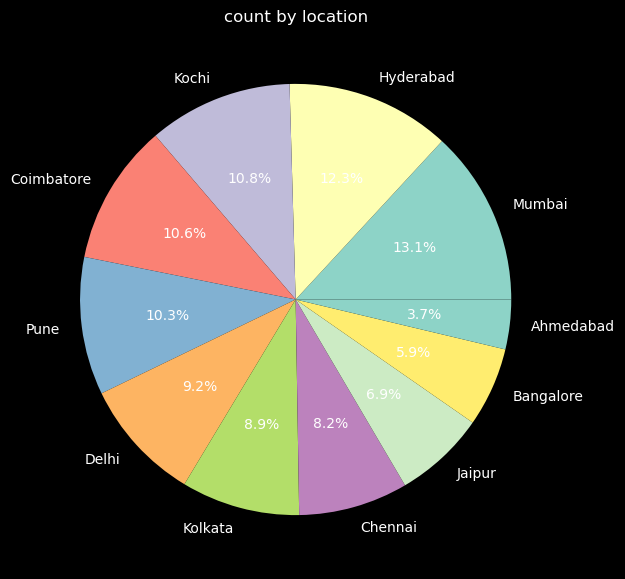

In [7]:
plt.figure(figsize=(7, 7))
plt.title('count by location')
plt.pie(x=train_df['Location'].value_counts(), labels=train_df['Location'].value_counts().index, autopct="%1.1f%%")
plt.show()

### Year

In [8]:
train_df['Year'].value_counts()

2014    797
2015    744
2016    741
2013    649
2017    587
2012    580
2011    466
2010    342
2018    298
2009    198
2008    174
2007    125
2019    102
2006     78
2005     57
2004     31
2003     17
2002     15
2001      8
2000      4
1998      4
1999      2
Name: Year, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


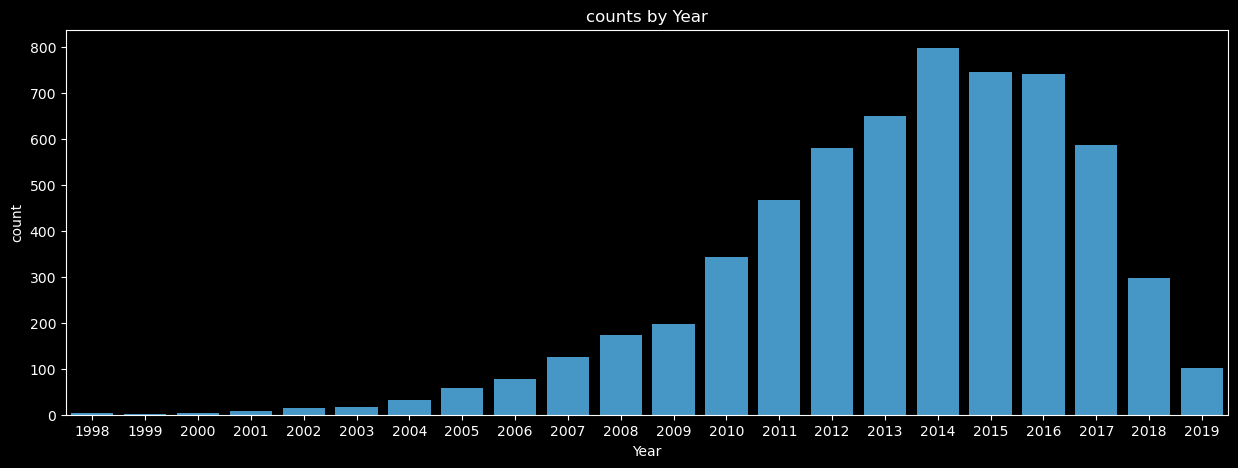

In [9]:
plt.figure(figsize=(15, 5))
plt.title('counts by Year')
sns.countplot(train_df['Year'], color='#329ddb')
plt.show()

### Kilometers_Driven

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


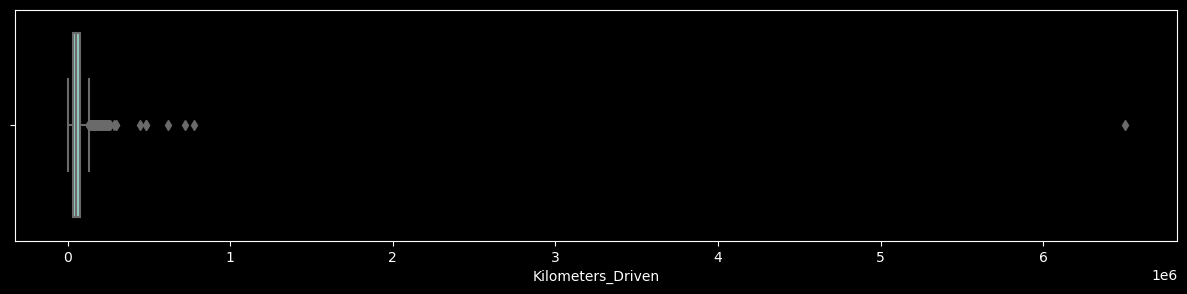

In [10]:
plt.figure(figsize=(15, 3))
sns.boxplot(train_df['Kilometers_Driven'])
plt.show()

### Fuel_Type

In [11]:
train_df['Fuel_Type'].value_counts()

Diesel      3205
Petrol      2746
CNG           56
LPG           10
Electric       2
Name: Fuel_Type, dtype: int64

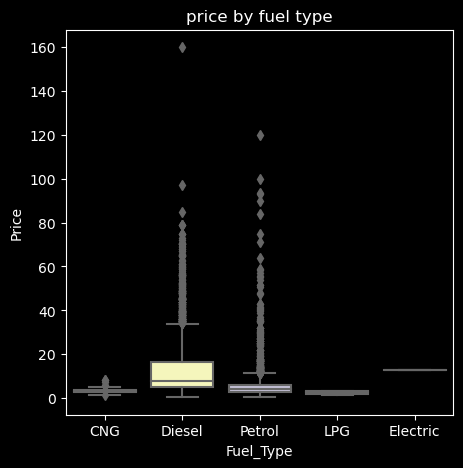

In [12]:
plt.figure(figsize=(5,5))
plt.title('price by fuel type')
sns.boxplot(x=train_df['Fuel_Type'], y=train_df['Price'])
plt.show()

### Transmission

In [13]:
train_df['Transmission'].value_counts()

Manual       4299
Automatic    1720
Name: Transmission, dtype: int64

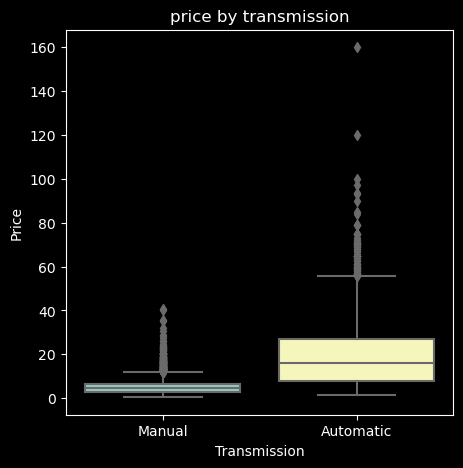

In [14]:
plt.figure(figsize=(5,5))
plt.title('price by transmission')
sns.boxplot(x=train_df['Transmission'], y=train_df['Price'])
plt.show()

### Owner_type

In [15]:
train_df['Owner_Type'].value_counts()

First             4929
Second             968
Third              113
Fourth & Above       9
Name: Owner_Type, dtype: int64

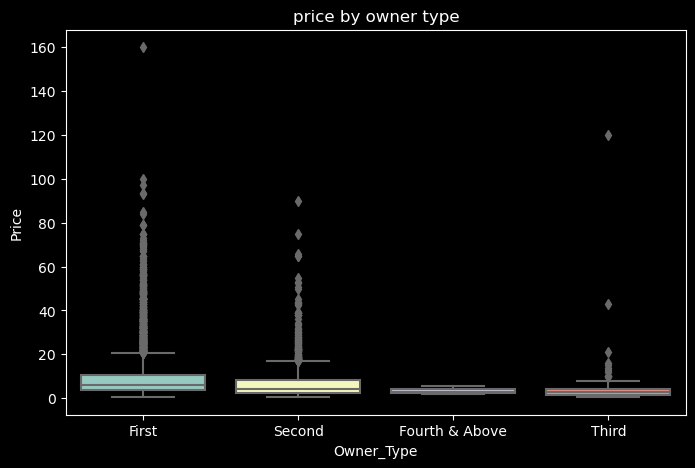

In [16]:
plt.figure(figsize=(8, 5))
plt.title('price by owner type')
sns.boxplot(x=train_df['Owner_Type'], y=train_df['Price'])
plt.show()

### Mileage, Engine, Power

In [17]:
features = ['Mileage', 'Engine', 'Power']
for feature in features:
    train_df[feature] = pd.to_numeric(train_df[feature].map(lambda x: str(x).split(" ")[0]),
                                      errors='coerce')
    test_df[feature] = pd.to_numeric(test_df[feature].map(lambda x: str(x).split(" ")[0]),
                                     errors='coerce')


array([[<AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Engine'}>],
       [<AxesSubplot:title={'center':'Power'}>, <AxesSubplot:>]],
      dtype=object)

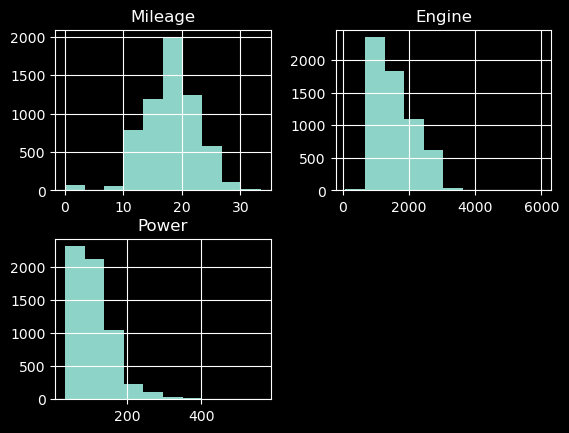

In [18]:
train_df[features].hist()

### Seats

In [19]:
train_df['Seats'].value_counts()

5.0     5014
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
0.0        1
Name: Seats, dtype: int64

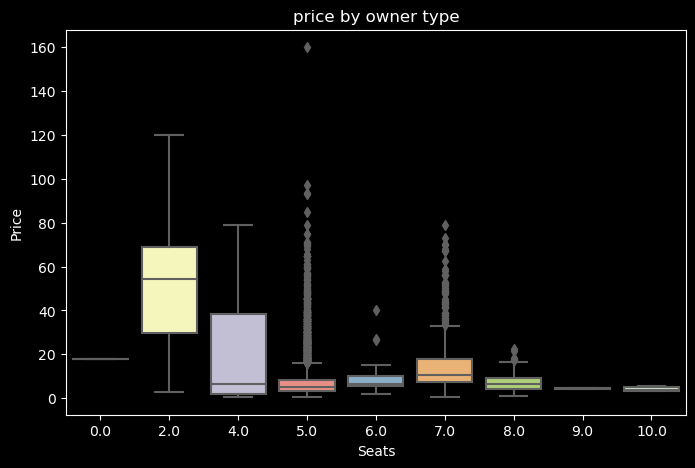

In [20]:
plt.figure(figsize=(8, 5))
plt.title('price by owner type')
sns.boxplot(x=train_df['Seats'], y=train_df['Price'])
plt.show()

### Heatmap corr

<AxesSubplot:>

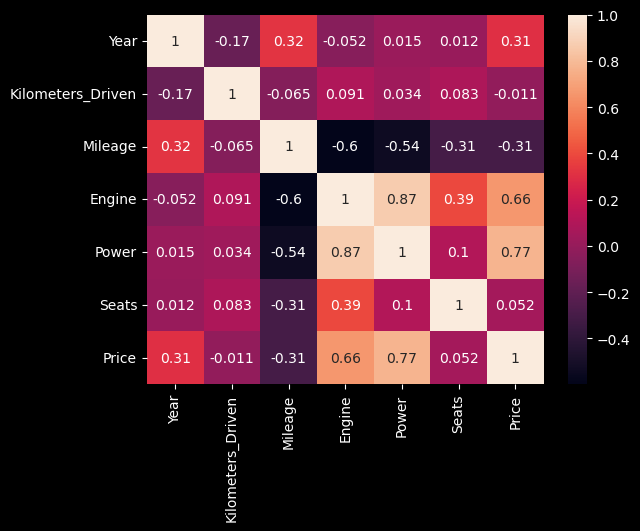

In [21]:
sns.heatmap(train_df.corr(), annot=True)

### Price depends on the year

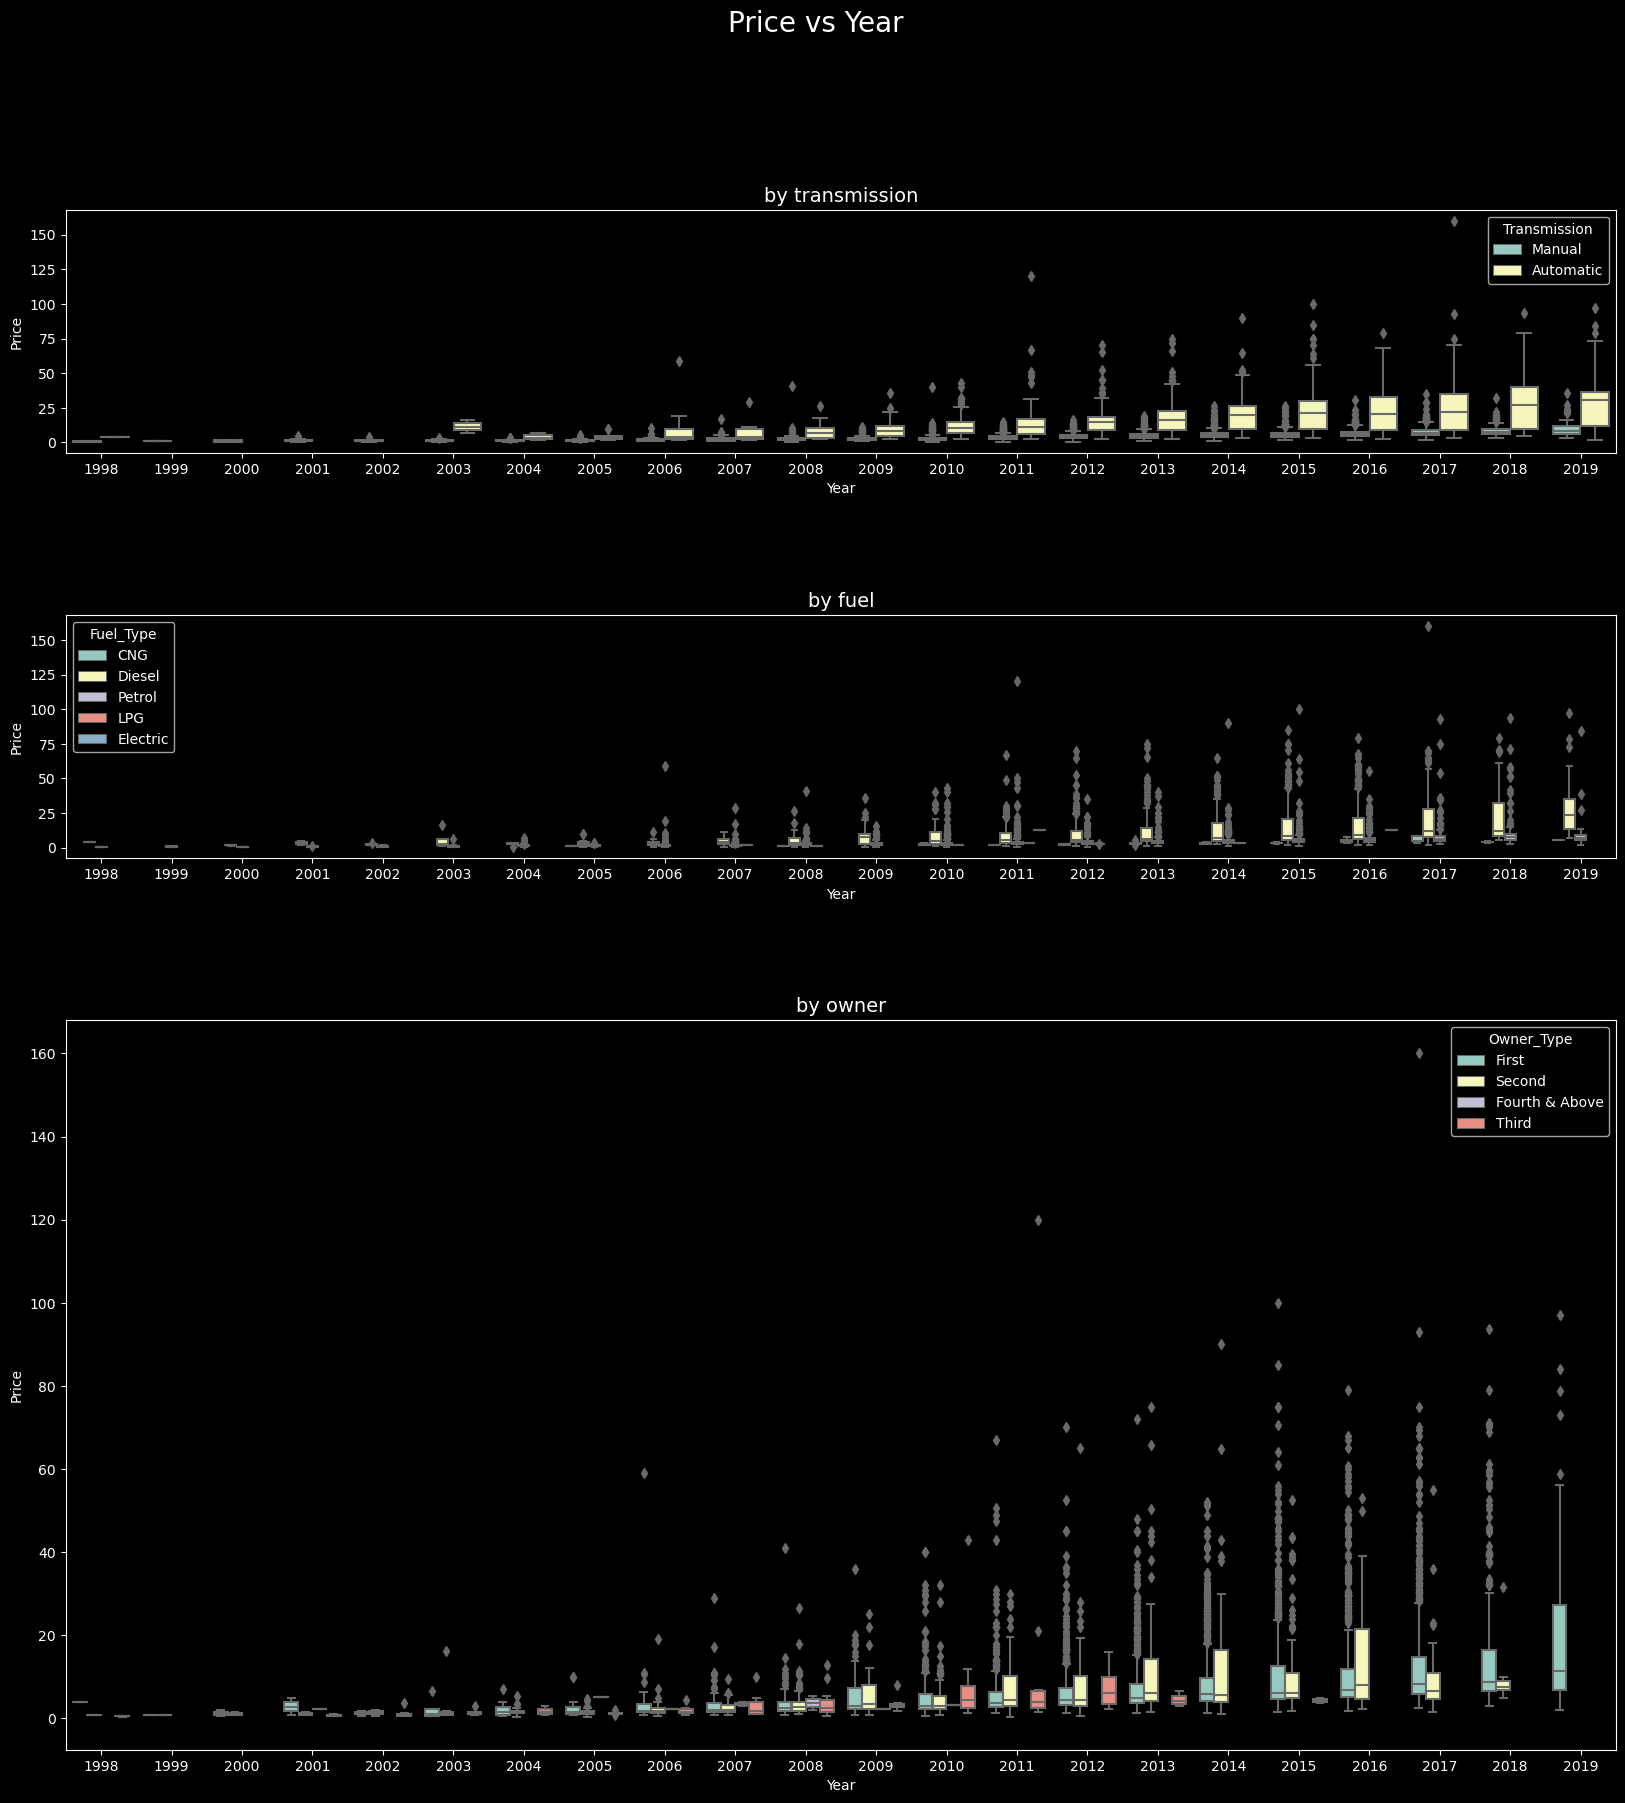

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 20), gridspec_kw={'height_ratios': [2, 2, 6]} )
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Price vs Year', size = 20)
#by transmission
sns.boxplot(ax=ax0, x=train_df['Year'], y=train_df['Price'], hue=train_df['Transmission'])
ax0.set_title('by transmission', size=14)
#by fuel
sns.boxplot(ax=ax1, x=train_df['Year'], y=train_df['Price'], hue=train_df['Fuel_Type'])
ax1.set_title('by fuel', size=14)
# #by owner type
sns.boxplot(ax=ax2, x=train_df['Year'], y=train_df['Price'], hue=train_df['Owner_Type'])
ax2.set_title('by owner', size=14 )
plt.show()

## Data Cleaning

### Years

In [23]:
train_df['Year'] = np.where(train_df['Year'].astype(int) < 2000, 2000, train_df['Year'])
test_df['Year'] = np.where(test_df['Year'].astype(int) < 2000, 2000, test_df['Year'])

### Kilometers_Driven

In [24]:
#drop outlier
max_Kilometers_Driven = train_df['Kilometers_Driven'].max()
train_df.drop(train_df[train_df['Kilometers_Driven'] == max_Kilometers_Driven].index, axis=0, inplace=True)

### Fuel_Type

In [25]:
#drop Fuel_Type=='Electric'
train_df.drop(train_df[train_df['Fuel_Type'] == 'Electric'].index, axis=0, inplace=True)
test_df.drop(test_df[test_df['Fuel_Type'] == 'Electric'].index, axis=0, inplace=True)
#combining CNG and LPG into Gas
train_df['Fuel_Type'] = np.where(train_df['Fuel_Type'] == 'CNG', 'Gas',
                                 np.where(train_df['Fuel_Type'] == 'LPG', 'Gas', train_df['Fuel_Type']))
test_df['Fuel_Type'] = np.where(test_df['Fuel_Type'] == 'CNG', 'Gas',
                                np.where(test_df['Fuel_Type'] == 'LPG', 'Gas', test_df['Fuel_Type']))

### Transmission

In [26]:
train_df.drop(train_df[train_df['Price'] == 160].index, axis=0, inplace=True)

### Power

In [27]:
percentile_97 = np.nanpercentile(train_df['Power'], 97)
train_df.drop(train_df[train_df['Power'] > percentile_97].index, axis=0, inplace=True)

### Seats

In [28]:
train_df['Seats'] = np.where(train_df['Seats'] > 8, 8, train_df['Seats'])
test_df['Seats'] = np.where(test_df['Seats'] > 8, 8, test_df['Seats'])
#drop row where Seats == 0
train_df.drop(train_df[train_df['Seats'] == 0].index, axis=0, inplace=True)
test_df.drop(test_df[test_df['Seats'] == 0].index, axis=0, inplace=True)

## Features Engineering

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

max_year = train_df['Year'].max() + 1

# column index
year_ix, k_driven_ix, power_ix, seats_ix = 0, 1, 4, 5

class CreateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        average_yearthly_driven = X[:, k_driven_ix] / (max_year - X[:, year_ix])
        power_on_one_seats = X[:, power_ix] / X[:, seats_ix]
        return np.c_[X, average_yearthly_driven, power_on_one_seats]


## Model Pipeline

In [30]:
X = train_df.drop(['Price'], axis=1).copy()
y = train_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

num_features = ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats']
cat_features = ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type']

num_preparation_pipe = Pipeline(
    steps=[
        ('fillna', SimpleImputer(strategy='median')),
        ('features_adder', CreateFeatures()),
        ('scaler', MinMaxScaler())
    ]
)

cat_preparation_pipe = Pipeline(
    steps=[
        ('fillna', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder())
    ]
)

full_preparation = ColumnTransformer(
    transformers=[
        ('numeric', num_preparation_pipe, num_features),
        ('categorical', cat_preparation_pipe, cat_features)
    ]
)

model = Pipeline(steps=[
    ('preparation', full_preparation),
    ('model', XGBRegressor())])

In [31]:
model.fit(X_train, y_train)

print(f'MSE = {mean_squared_error(y_test, model.predict(X_test))}')

MSE = 5.515095147986603


## GridSearch

In [32]:
params = {
    'eta':[0.1, 0.2, 0.3, 0.4],
    'max_depth':[5, 7, 9, 10],
    'min_child_weight':[2, 3, 4],
    'n_estimators':[500, 1000, 1500]
}

grid_model = Pipeline(
    steps=[
        ('full_preparation', full_preparation),
        ('grid_cv_model', GridSearchCV(XGBRegressor(), param_grid=params, cv=5, verbose=False))
    ]
)

In [33]:
grid_model.fit(X_train, y_train)
print(f'MSE = {mean_squared_error(y_test, grid_model.predict(X_test))}')

MSE = 4.784274869587401


In [37]:
grid_model.named_steps['grid_cv_model'].best_params_

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 1500}

In [ ]:
best_params = {'eta': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 1500}

### Features importance

In [ ]:
categorical_cols = model.named_steps['preparation'].named_transformers_['categorical']\
                        .named_steps["encoder"].get_feature_names(cat_features)
# columns name
features_name = num_features + list(categorical_cols) + ['average_yearthly_driven', 'power_on_one_seats']

feature_importances = pd.DataFrame({'features':features_name,
                                    'feature importances':model.named_steps['model'].feature_importances_})
feature_importances.sort_values('feature importances', ascending=False)

Final MSE on grid search = 4.784274869587401